<a href="https://colab.research.google.com/github/kaushalshah178/Brain-Tumor-Multiclass-Classification-and-Segmentation/blob/main/mri.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q keras

In [ ]:
import keras

In [ ]:
import os
import random
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img,ImageDataGenerator, array_to_img
from tensorflow.keras.applications import EfficientNetB1

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten,Dense,Conv2D,Dropout,GlobalAveragePooling2D

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
import imutils 

In [ ]:

os.mkdir("/content/Crop-Brain-MRI")
os.mkdir("/content/Crop-Brain-MRI/glioma_tumor")
os.mkdir("/content/Crop-Brain-MRI/meningioma_tumor")
os.mkdir("/content/Crop-Brain-MRI/no_tumor")
os.mkdir("/content/Crop-Brain-MRI/pituitary_tumor")

In [ ]:

os.mkdir("/content/Test-Data")
os.mkdir("/content/Test-Data/glioma_tumor")
os.mkdir("/content/Test-Data/meningioma_tumor")
os.mkdir("/content/Test-Data/no_tumor")
os.mkdir("/content/Test-Data/pituitary_tumor")

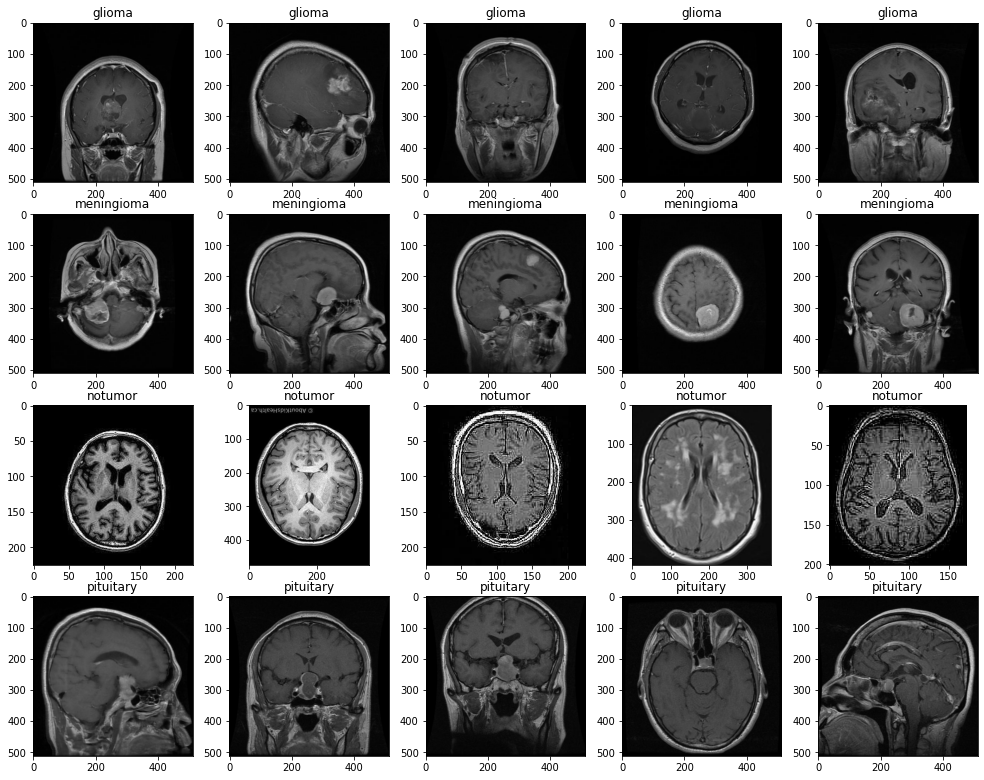

In [ ]:
train_dir = "/content/drive/MyDrive/Colab Notebooks/mri_project/tumor_classification/Training/"
test_dir = "/content/drive/MyDrive/Colab Notebooks/mri_project/tumor_classification/Testing/"
classes = os.listdir("/content/drive/MyDrive/Colab Notebooks/mri_project/tumor_classification/Training/")
files_path_dict = {}
for c in classes:
  files_path_dict[c] = list(map(lambda x :train_dir + c + '/' + x, os.listdir(train_dir + c)))


plt.figure(figsize = (17,17))
index = 0

for c in classes:
  random.shuffle(files_path_dict[c])
  path_list = files_path_dict[c][:6]

  for i in range(1, 6):
    index += 1
    plt.subplot(5, 5, index)
    plt.imshow(load_img(path_list[i]))
    plt.title(c)

In [ ]:
def crop_image(image, plot=False):
    
    img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    img_gray = cv2.GaussianBlur(img_gray, (5, 5), 0)
    
    img_thresh = cv2.threshold(img_gray, 45, 255, cv2.THRESH_BINARY)[1]
    img_thresh = cv2.erode(img_thresh, None, iterations=2)
    img_thresh = cv2.dilate(img_thresh, None, iterations=2)

    contours = cv2.findContours(img_thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(contours)
    c = max(contours, key=cv2.contourArea)

    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.tick_params(axis='both', which='both', top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Original Image')
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)
        plt.tick_params(axis='both', which='both',top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Cropped Image')
        plt.show()
    
    return new_image

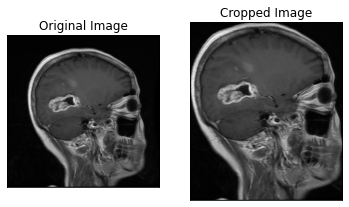

In [ ]:
example_img = cv2.imread("/content/drive/MyDrive/Colab Notebooks/mri_project/tumor_classification/Training/glioma/Tr-gl_1213.jpg")
copped_image = crop_image(example_img, plot=True)

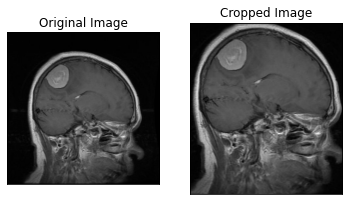

In [ ]:
example_img1 = cv2.imread("/content/drive/MyDrive/Colab Notebooks/mri_project/tumor_classification/Training/meningioma/Tr-me_1209.jpg")
copped_image1 = crop_image(example_img1, plot=True)

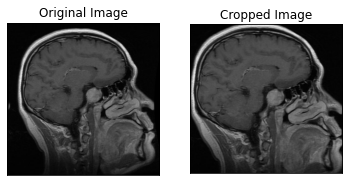

In [ ]:
example_img2 = cv2.imread("/content/drive/MyDrive/Colab Notebooks/mri_project/tumor_classification/Training/pituitary/Tr-pi_0893.jpg")
copped_image2 = crop_image(example_img2, plot=True)

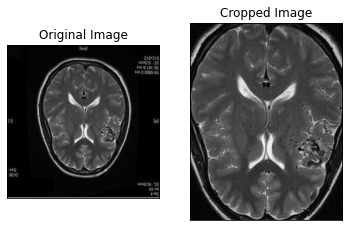

In [ ]:
example_img3 = cv2.imread("/content/drive/MyDrive/Colab Notebooks/mri_project/tumor_classification/Training/notumor/Tr-no_0612.jpg")
copped_image3 = crop_image(example_img3, plot=True)

In [ ]:

glioma = train_dir + "glioma"
meningioma = train_dir + "meningioma"
no_tumor = train_dir + "notumor"
pituitary = train_dir + "pituitary"

j = 0
for i in tqdm(os.listdir(glioma)):
  path = os.path.join(glioma, i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)
  if img is not None:
    img = cv2.resize(img, (224, 224))
    save_path = "/content/Crop-Brain-MRI/glioma_tumor/" + str(j) + ".jpg"
    cv2.imwrite(save_path, img)
    j = j + 1

j = 0
for i in tqdm(os.listdir(meningioma)):
  path = os.path.join(meningioma, i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)
  if img is not None:
    img = cv2.resize(img, (224, 224))
    save_path = "/content/Crop-Brain-MRI/meningioma_tumor/" + str(j) + ".jpg"
    cv2.imwrite(save_path, img)
    j = j + 1

j = 0
for i in tqdm(os.listdir(no_tumor)):
  path = os.path.join(no_tumor, i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)
  if img is not None:
    img = cv2.resize(img, (224, 224))
    save_path = "/content/Crop-Brain-MRI/no_tumor/" + str(j) + ".jpg"
    cv2.imwrite(save_path, img)
    j = j + 1

j = 0
for i in tqdm(os.listdir(pituitary)):
  path = os.path.join(pituitary, i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)
  if img is not None:
    img = cv2.resize(img, (224, 224))
    save_path = "/content/Crop-Brain-MRI/pituitary_tumor/" + str(j) + ".jpg"
    cv2.imwrite(save_path, img)
    j = j + 1

100%|██████████| 1457/1457 [00:30<00:00, 47.87it/s]


In [ ]:

test_glioma = test_dir + "glioma"
test_meningioma = test_dir + "meningioma"
test_no_tumor = test_dir + "notumor"
test_pituitary = test_dir + "pituitary"

j = 0
for i in tqdm(os.listdir(test_glioma)):
  path = os.path.join(test_glioma, i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)
  if img is not None:
    img = cv2.resize(img, (224, 224))
    save_path = "/content/Test-Data/glioma_tumor/" + str(j) + ".jpg"
    cv2.imwrite(save_path, img)
    j = j + 1

j = 0
for i in tqdm(os.listdir(test_meningioma)):
  path = os.path.join(test_meningioma, i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)
  if img is not None:
    img = cv2.resize(img, (224, 224))
    save_path = "/content/Test-Data/meningioma_tumor/" + str(j) + ".jpg"
    cv2.imwrite(save_path, img)
    j = j + 1

j = 0
for i in tqdm(os.listdir(test_no_tumor)):
  path = os.path.join(test_no_tumor, i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)
  if img is not None:
    img = cv2.resize(img, (224, 224))
    save_path = "/content/Test-Data-MRI/no_tumor/" + str(j) + ".jpg"
    cv2.imwrite(save_path, img)
    j = j + 1

j = 0
for i in tqdm(os.listdir(test_pituitary)):
  path = os.path.join(test_pituitary, i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)
  if img is not None:
    img = cv2.resize(img, (224, 224))
    save_path = "/content/Test-Data/pituitary_tumor/" + str(j) + ".jpg"
    cv2.imwrite(save_path, img)
    j = j + 1

100%|██████████| 300/300 [00:06<00:00, 43.19it/s]


In [ ]:
# Use Image Data Generator to perform this task.
datagen = ImageDataGenerator(rotation_range=10, height_shift_range=0.2, horizontal_flip=True, validation_split=0.2)
train_data = datagen.flow_from_directory('/content/Crop-Brain-MRI/',target_size = (224, 224), batch_size = 32,class_mode = 'categorical',subset = 'training')

valid_data = datagen.flow_from_directory('/content/Crop-Brain-MRI/',target_size = (224, 224),batch_size = 32,class_mode = 'categorical',subset = 'validation')

test_datagen = ImageDataGenerator()

test_data = datagen.flow_from_directory('/content/Test-Data/',target_size = (224, 224),class_mode = 'categorical',)

Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.
Found 906 images belonging to 4 classes.


In [ ]:

print(train_data.class_indices)
print(test_data.class_indices)

{'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}
{'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}


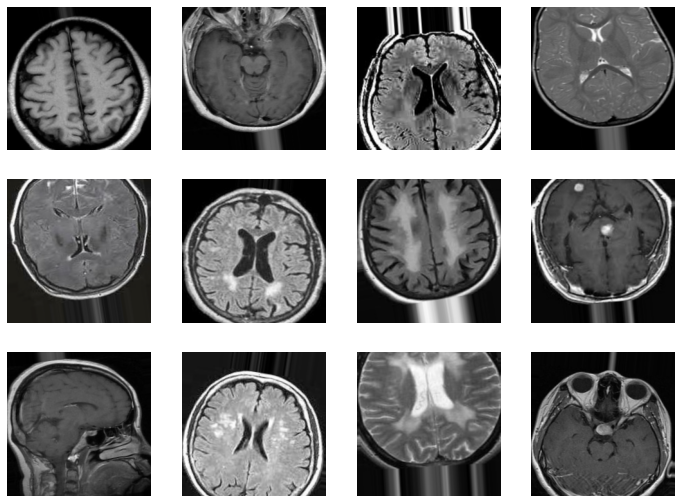

In [ ]:
# View the augmented data.
sample_x, sample_y = next(train_data)
plt.figure(figsize = (12,9))
for i in range (12):
  plt.subplot(3, 4, i + 1)
  sample = array_to_img(sample_x[i])
  plt.axis('off')
  plt.grid(False)
  plt.imshow(sample)
plt.show()

In [ ]:
# Build the Model
effnet = EfficientNetB1(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

model = effnet.output
model = GlobalAveragePooling2D()(model)
model = Dropout(0.5)(model)
model = Dense(4, activation="softmax")(model)
model = Model(inputs = effnet.input, outputs = model)

model.summary()

27033600/27018416 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])
checkpoint = ModelCheckpoint("model.h5", monitor="val_accurary", save_best_only=True, mode="auto", verbose=1)
earlystopping = EarlyStopping(monitor="val_accuracy", patience=5, mode="auto", verbose=1)

In [ ]:
# Train the model
history = model.fit(train_data, epochs=7, validation_data=valid_data, verbose=1, callbacks=[checkpoint, earlystopping])

Epoch 1/7
143/143 [==============================] - 169s 968ms/step - loss: 0.5305 - accuracy: 0.8068 - val_loss: 0.7862 - val_accuracy: 0.6836
Epoch 2/7
143/143 [==============================] - 133s 931ms/step - loss: 0.1685 - accuracy: 0.9414 - val_loss: 0.3390 - val_accuracy: 0.8624
Epoch 3/7
143/143 [==============================] - 133s 927ms/step - loss: 0.1022 - accuracy: 0.9663 - val_loss: 0.2475 - val_accuracy: 0.9106
Epoch 4/7
143/143 [==============================] - 133s 929ms/step - loss: 0.0670 - accuracy: 0.9781 - val_loss: 0.1311 - val_accuracy: 0.9553
Epoch 5/7
143/143 [==============================] - 133s 928ms/step - loss: 0.0477 - accuracy: 0.9845 - val_loss: 0.1084 - val_accuracy: 0.9588
Epoch 6/7
143/143 [==============================] - 133s 925ms/step - loss: 0.0429 - accuracy: 0.9875 - val_loss: 0.0864 - val_accuracy: 0.9746
Epoch 7/7
143/143 [==============================] - 133s 929ms/step - loss: 0.0297 - accuracy: 0.9908 - val_loss: 0.0927 - val_ac

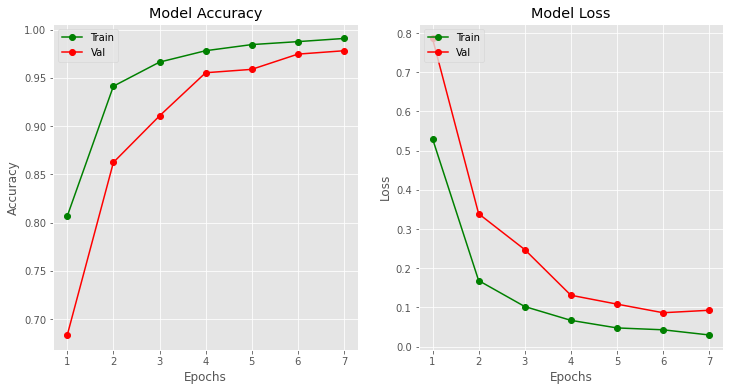

In [ ]:
plt.style.use("ggplot")
plt.figure(figsize=(12, 6))
epochs = range(1, 8)
plt.subplot(1, 2, 1)
plt.plot(epochs, history.history["accuracy"], "go-")
plt.plot(epochs, history.history["val_accuracy"], "ro-")
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Train", "Val"], loc="upper left")

plt.subplot(1, 2, 2)
plt.plot(epochs, history.history["loss"], "go-")
plt.plot(epochs, history.history["val_loss"], "ro-")
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Train", "Val"], loc="upper left")
plt.show()

pituitary_tumor


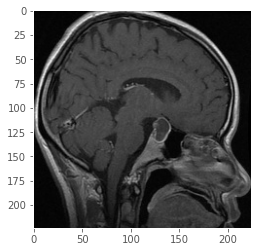

In [ ]:
# Obtain Predictions on Test Images for Pituitary Tumor
class_dict = {0: "glioma_tumor", 1:"meningioma_tumor", 2:"no_tumor", 3:"pituitary_tumor"}

test_img1 = cv2.imread("/content/Test-Data/pituitary_tumor/4.jpg")
plt.imshow(test_img1)
plt.grid(False)
test_img1 = np.expand_dims(test_img1, axis=0)
pred = model.predict(test_img1)
pred = np.argmax(pred)
pred_class = class_dict[pred]
print(pred_class)

meningioma_tumor


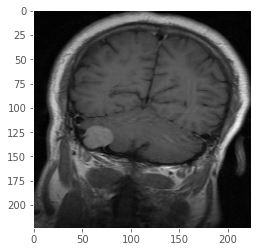

In [ ]:
# Obtain Predictions on Test Images for Meningioma Tumor
class_dict = {0: "glioma_tumor", 1:"meningioma_tumor", 2:"no_tumor", 3:"pituitary_tumor"}

test_img2 = cv2.imread("/content/Test-Data/meningioma_tumor/2.jpg")
plt.imshow(test_img2)
plt.grid(False)
test_img2 = np.expand_dims(test_img2, axis=0)
pred = model.predict(test_img2)
pred = np.argmax(pred)
pred_class = class_dict[pred]
print(pred_class)

glioma_tumor


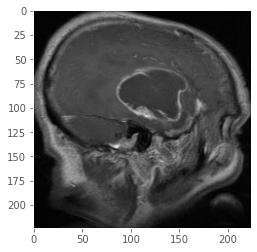

In [ ]:
# Obtain Predictions on Test Images for Meningioma Tumor
class_dict = {0: "glioma_tumor", 1:"meningioma_tumor", 2:"no_tumor", 3:"pituitary_tumor"}

test_img2 = cv2.imread("/content/Test-Data/glioma_tumor/10.jpg")
plt.imshow(test_img2)
plt.grid(False)
test_img2 = np.expand_dims(test_img2, axis=0)
pred = model.predict(test_img2)
pred = np.argmax(pred)
pred_class = class_dict[pred]
print(pred_class)